In [1]:
import pandas as pd
import numpy as np
import pickle
import json
import pyspark as sc
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from tensorflow.python.platform import gfile
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix

# make plot outputs appear and be stored within this notebook
%matplotlib inline 

# Set figure visual attributes
sns.set(style = 'whitegrid', palette = 'muted', font_scale = 1.5)

# Set figure size 
rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

C:\Users\Jenario\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [65]:
# Set Column Header Labels
columns = ['date', 'time', 'freq', 'pwr', 'type']

# Create pandas dataframe 'df' by reading in csv file or txt file in this case
df = pd.read_csv('RFDataFull.txt', parse_dates=['time'], header = None, names = columns)

df['freq'] = df['freq'].str.replace(',', '')
df['time'] = df['time'].str.replace(' ', '')
#df["freq"] = pd.to_numeric(df["freq"])
#df.columns = [col.replace(',', '') for col in df.columns]
# this converts the module, pwr, and freq columns to ints and floats
df[['pwr', 'freq']] = df[['pwr', 'freq']].apply(pd.to_numeric)

#df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S.%f')

# Remove missing values
df = df.dropna()

C:\Users\Jenario\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [66]:
# output table of first fize values
df.head()

,date,time,freq,pwr,type
131072,March 13th 2018,1900-01-01 15:41:46.096,1.738000e+09,-61.736,normal
131073,March 13th 2018,1900-01-01 15:41:46.061,1.720000e+09,-22.407,normal
131074,March 13th 2018,1900-01-01 15:41:46.012,1.735000e+09,-53.508,normal
131075,March 13th 2018,1900-01-01 15:41:45.980,1.718000e+09,-60.084,normal
131076,March 13th 2018,1900-01-01 15:41:45.963,2.442000e+09,-43.609,normal


In [79]:
# output summary of data in file
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42843 entries, 131072 to 173914
Data columns (total 5 columns):
date    42843 non-null object
time    42843 non-null datetime64[ns]
freq    42843 non-null float64
pwr     42843 non-null float64
type    42843 non-null object
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 3.2+ MB


In [80]:
# output a descriptivetable of the numerical attributes of our dataset
df.describe()

,freq,pwr
count,4.284300e+04,42843.000000
mean,1.751557e+09,-35.738738
std,7.236522e+08,15.557299
min,7.100000e+08,-94.937000
25%,9.084200e+08,-44.989000
50%,1.995000e+09,-36.685000
75%,2.436000e+09,-22.135000
max,2.495000e+09,-7.046000


In [81]:
df["type"].value_counts()

normal    38391
jamm       3627
replay      825
Name: type, dtype: int64

In [110]:
def plot_activity(activity, df):
    data = df[df['type'] == activity][['pwr', 'freq', 'time']][:800]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

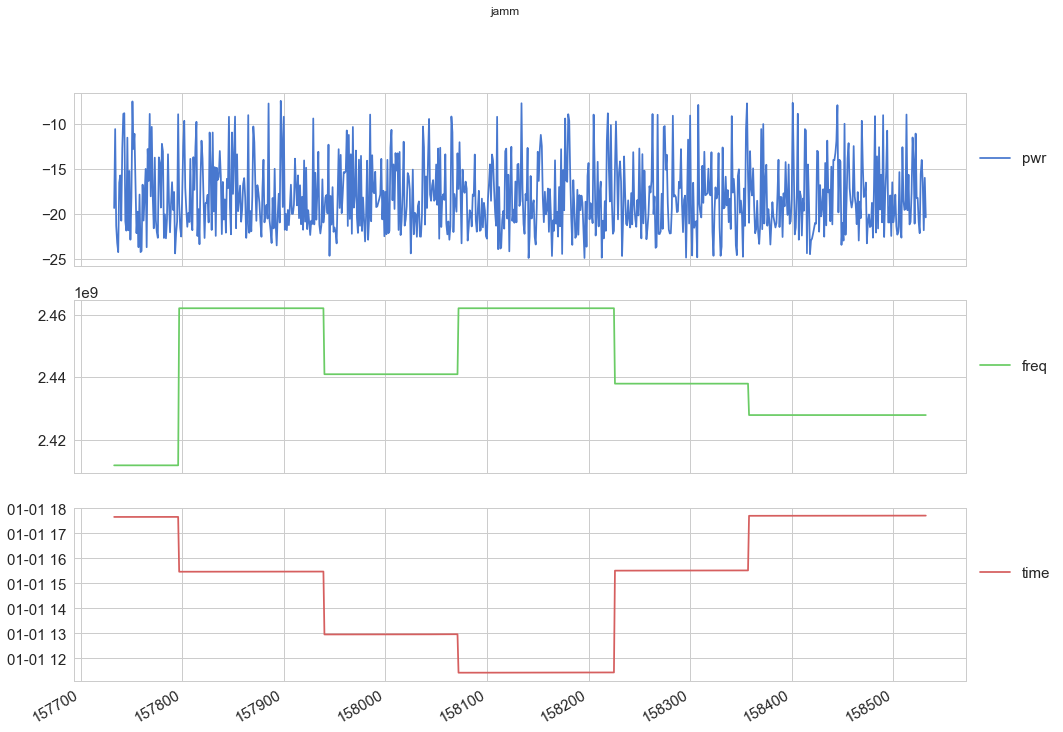

In [111]:
plot_activity("jamm", df)

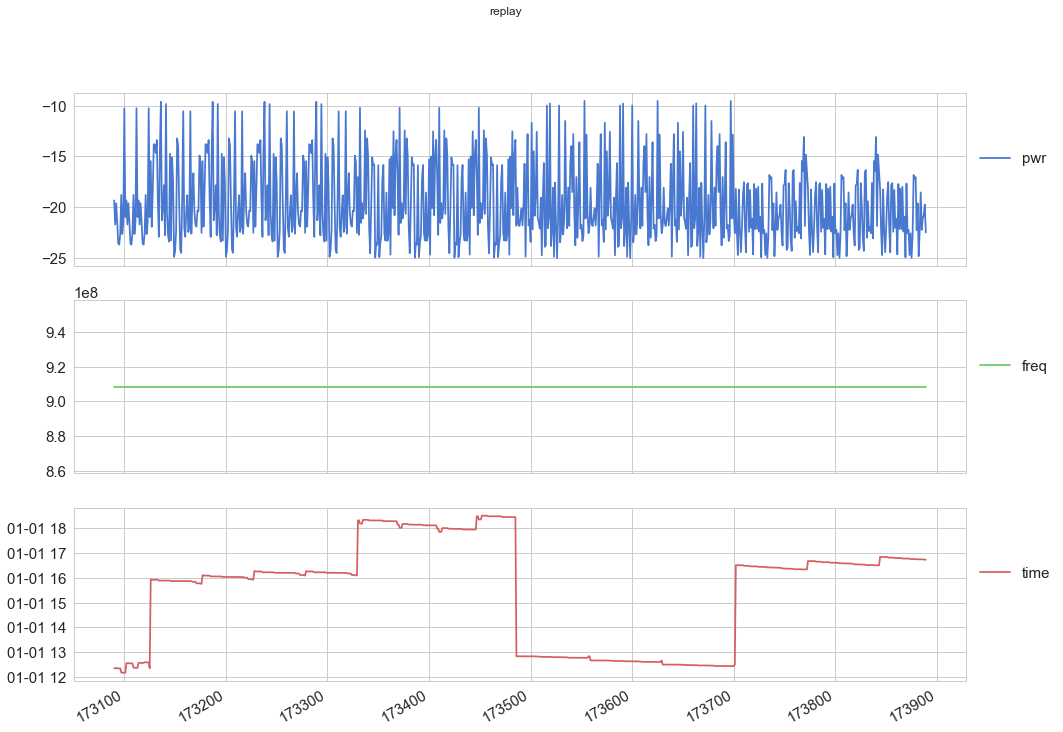

In [112]:
plot_activity("replay", df)

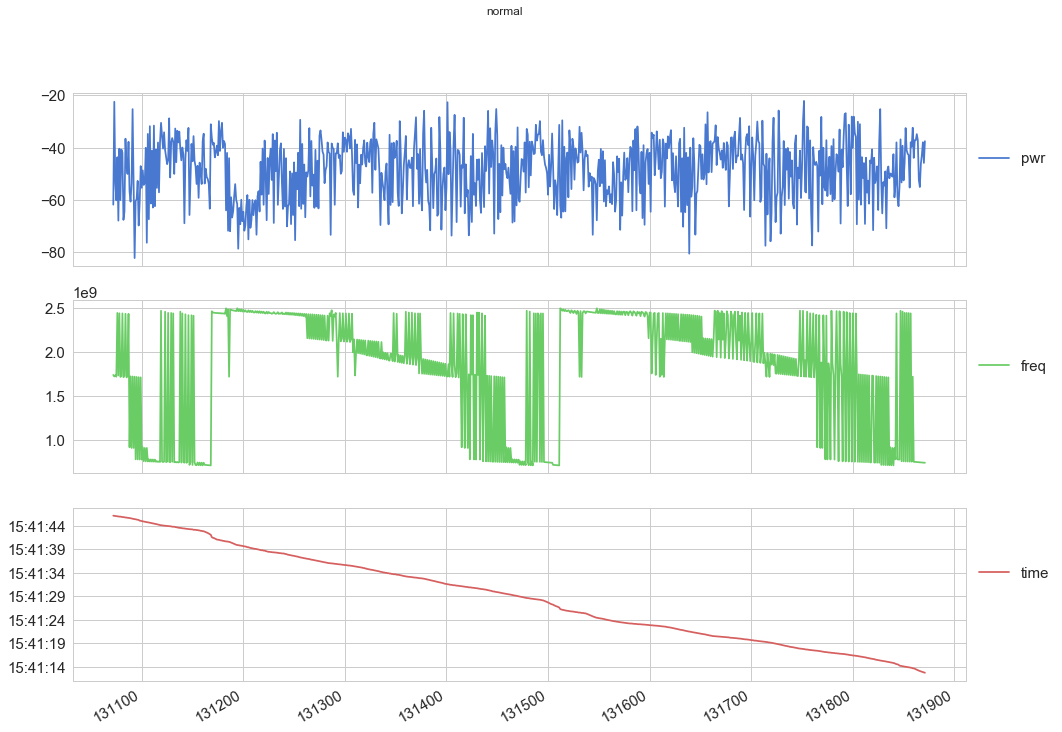

In [113]:
plot_activity("normal", df)

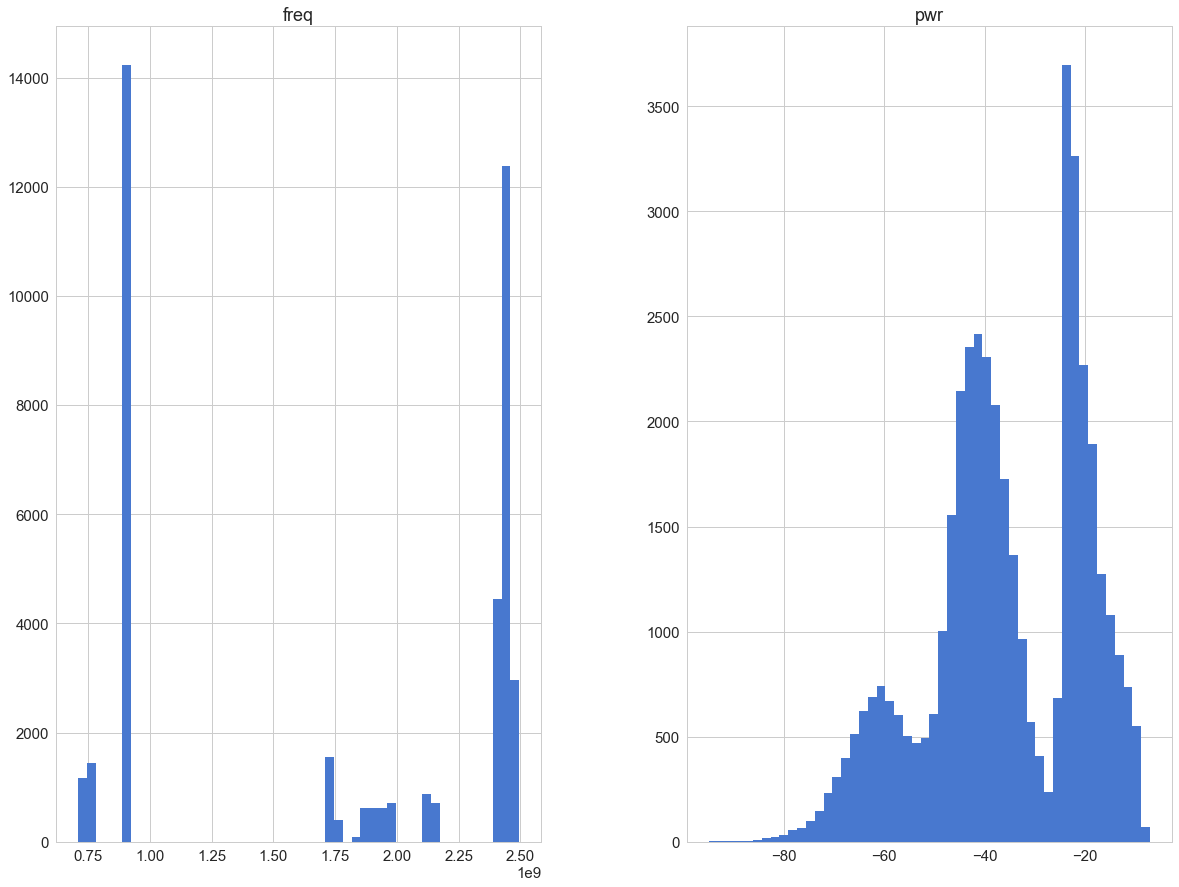

In [114]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000014D1930AEB8>,
      dtype=object)

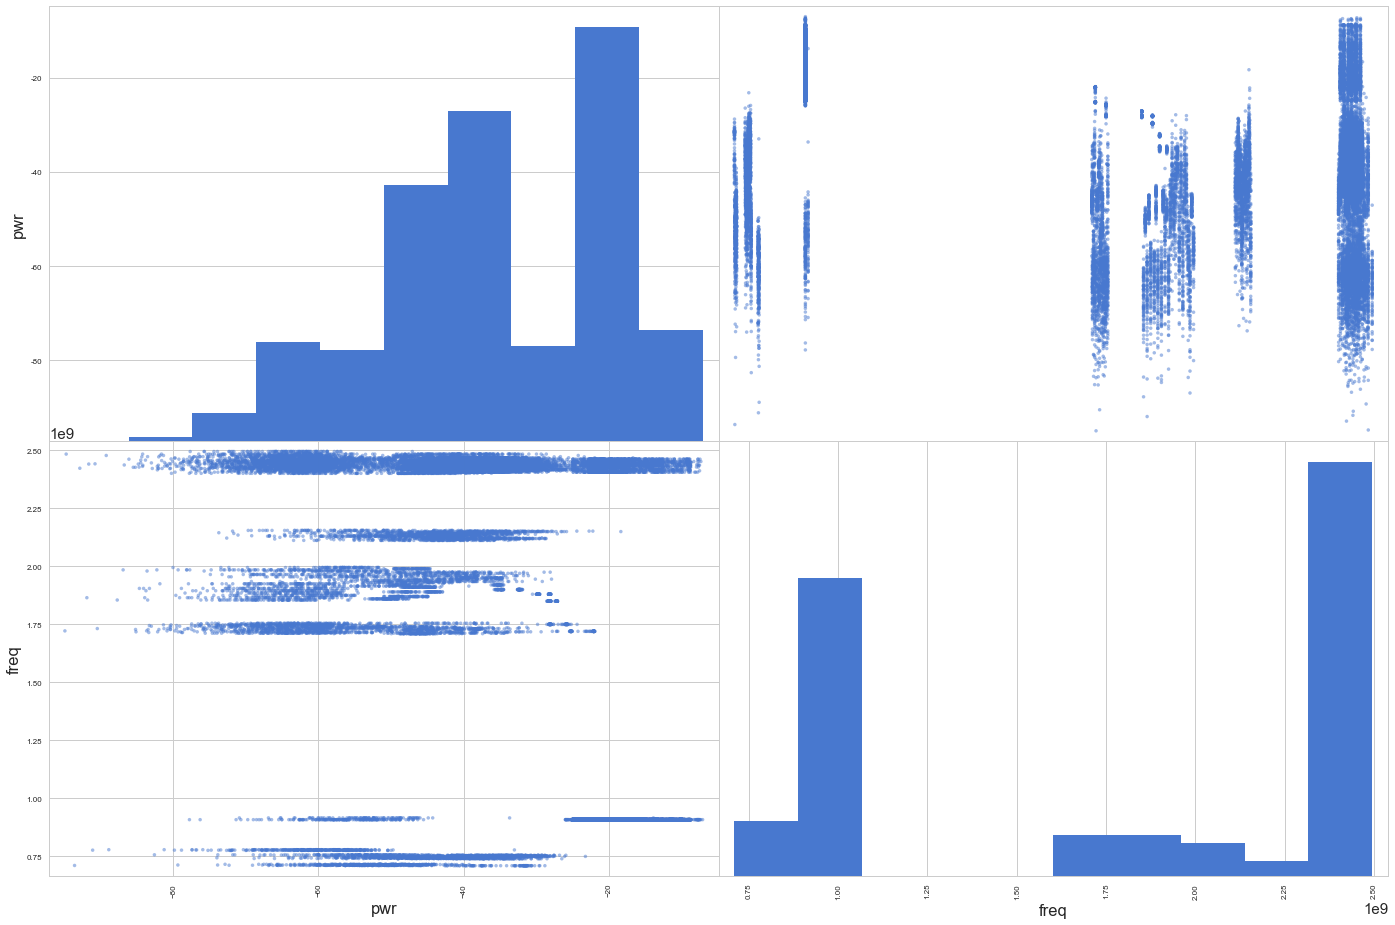

In [144]:
attributes = ["time", "pwr", "freq"]
scatter_matrix(df[attributes], figsize = (24, 16))

In [145]:
N_TIME_STEPS = 50;
N_FEATURES = 3;
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    fq = df['freq'].values[i: i + N_TIME_STEPS]
    pw = df['pwr'].values[i: i + N_TIME_STEPS]
    tm = df['time'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['type'][i: i + N_TIME_STEPS])[0][0]
    segments.append([fq, pw, tm])
    labels.append(label)

C:\Users\Jenario\Anaconda3\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [146]:
np.array(segments).shape

(2140, 3, 50)

In [147]:
new_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)

labels = np.asarray(pd.get_dummies(labels),dtype = np.float32)

In [148]:
new_segments.shape

(2140, 50, 3)

In [151]:
labels

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [152]:
# randomly split dataset into 80% training and 20% testing
#train_set, test_set = train_test_split(df, test_size = 0.2, random_state = RANDOM_SEED)

In [153]:
X_train, X_test, y_train, y_test = train_test_split(new_segments, labels, test_size = 0.2, random_state = RANDOM_SEED)

In [154]:
len(X_train)

1712

In [155]:
len(X_test)

428

In [156]:
N_CLASSES = 3
N_HIDDEN_UNITS = 64

In [157]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [158]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name = "input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

In [159]:
pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name = "y_")

In [160]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [161]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

In [162]:
N_EPOCHS = 50
BATCH_SIZE = 1024

In [163]:
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    if i != 1 and i % 10 != 0:
        continue

    print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final}')

epoch: 1 test accuracy: 0.9112149477005005 loss: 1.015599012374878
epoch: 10 test accuracy: 0.9112149477005005 loss: 0.8740870952606201
epoch: 20 test accuracy: 0.9065420627593994 loss: 0.839042067527771
epoch: 30 test accuracy: 0.90887850522995 loss: 0.7398598194122314
epoch: 40 test accuracy: 0.9112149477005005 loss: 0.7286709547042847
epoch: 50 test accuracy: 0.9112149477005005 loss: 0.7298094630241394

final results: accuracy: 0.9112149477005005 loss: 0.7298094630241394


In [165]:
pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', './checkpoint/har.pbtxt')  
saver.save(sess, save_path = "./checkpoint/har.ckpt")
sess.close()

In [166]:
history = pickle.load(open("history.p", "rb"))
predictions = pickle.load(open("predictions.p", "rb"))

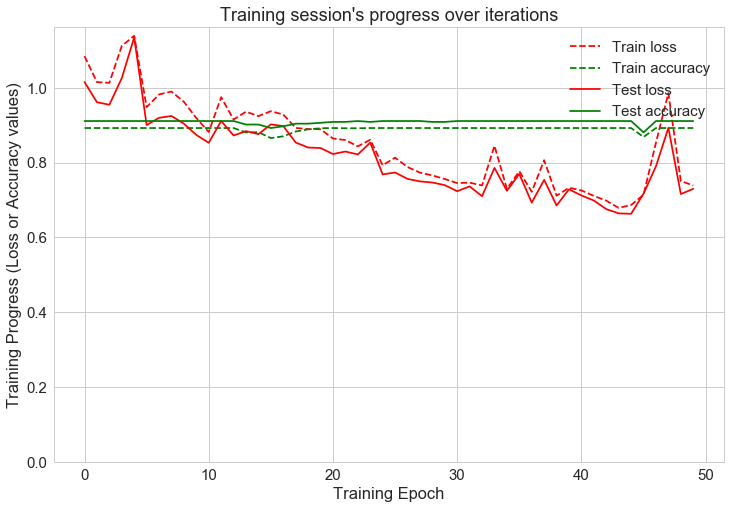

In [167]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

In [168]:
LABELS = ["Normal", "Jamming", "Replay"]

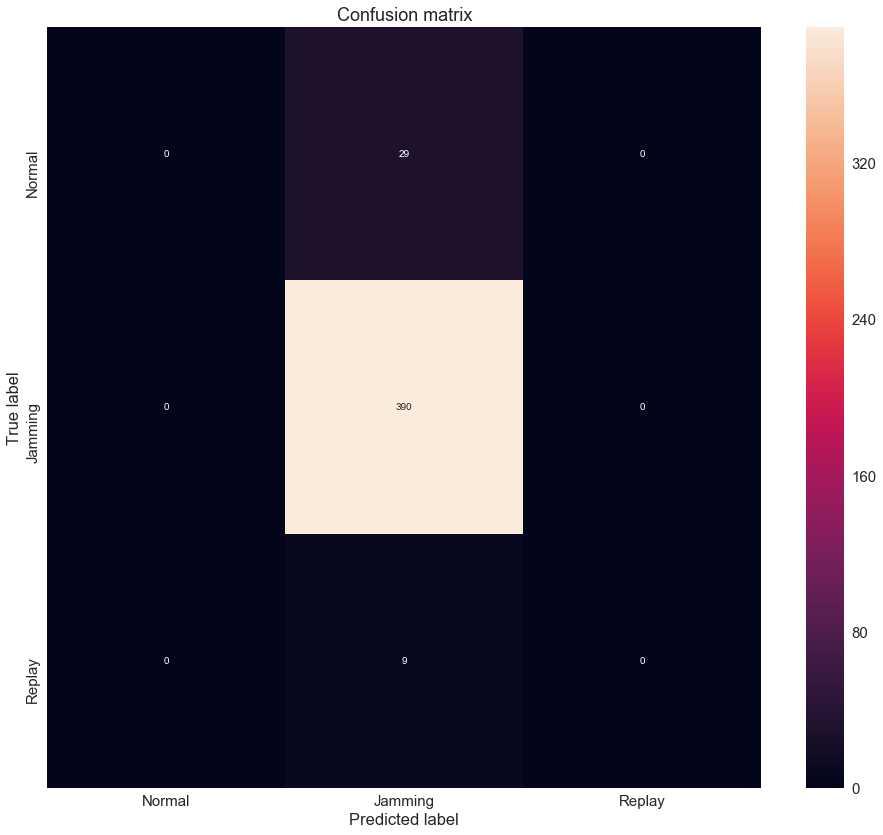

In [169]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

In [170]:
from tensorflow.python.tools import freeze_graph

MODEL_NAME = 'har'

input_graph_path = 'checkpoint/' + MODEL_NAME+'.pbtxt'
checkpoint_path = './checkpoint/' +MODEL_NAME+'.ckpt'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = 'frozen_'+MODEL_NAME+'.pb'

freeze_graph.freeze_graph(input_graph_path, input_saver="",
                          input_binary=False, input_checkpoint=checkpoint_path, 
                          output_node_names="y_", restore_op_name="save/restore_all",
                          filename_tensor_name="save/Const:0", 
                          output_graph=output_frozen_graph_name, clear_devices=True, initializer_nodes="")

INFO:tensorflow:Restoring parameters from ./checkpoint/har.ckpt
INFO:tensorflow:Froze 8 variables.
Converted 8 variables to const ops.
